# time series of europe heat waves

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy as cart
import cartopy.crs as ccrs
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy as cart
import seaborn as sns
from scipy import stats
import geopandas as gp
from cartopy import util
import pyreadr

In [2]:
dir = "/your/path/to/project/folder/"

In [3]:
loc_panel = dir+"Data/Panel/"
loc_eobs = dir+"Data/E-OBS/"
loc_figs = dir+"Figures/"
loc_events = dir+"Events/"

In [4]:
fname = "e-obs_nuts3_daily_tmean_popweight_1994-2023.csv"
eobs_daily = pd.read_csv(loc_eobs+fname,index_col=0).loc[:,["time","year","NUTS_ID","CNTR_CODE","LEVL_CODE","tm","tm_clm","tm_anom"]]
eobs_daily1 = eobs_daily.loc[(eobs_daily.LEVL_CODE==3)&(eobs_daily.year<=2023),:]
eobs_daily2 = eobs_daily.loc[(eobs_daily.LEVL_CODE==1)&(eobs_daily.CNTR_CODE=="DE")&(eobs_daily.year<=2023),:]
eobs_daily_final = pd.concat([eobs_daily1,eobs_daily2])
del([eobs_daily,eobs_daily1,eobs_daily2])

Slice to events

In [5]:
#event_yrs = [1994,2003,2006,2019,2022]
event_yrs = [1994,2003,2006,2019,2023]
eobs_daily_events = eobs_daily_final.loc[[x in event_yrs for x in eobs_daily_final.year.values],:]
del(eobs_daily_final)

Read weekly panel just to get population

In [7]:
weekly_panel = pyreadr.read_r(loc_panel+"eurostat_eobs_weekly_mortality_temperature_2000-2022.rds")[None].loc[:,["nuts","year","age","rate","population"]]
weekly_pop = weekly_panel.loc[weekly_panel.age=="total",:].drop(columns="age").rename(columns={"nuts":"NUTS_ID"})
weekly_pop_mean = weekly_pop.loc[(weekly_pop.year>=2015)&(weekly_pop.year<=2019),:].groupby(["NUTS_ID"]).mean().reset_index().drop(columns="year")
del([weekly_panel,weekly_pop])

In [8]:
eobs_daily_events_pop = pd.merge(eobs_daily_events,weekly_pop_mean,how="left",on=["NUTS_ID"]) #,"year"])

In [9]:
eobs_daily_events_pop["month"] = pd.to_datetime(eobs_daily_events_pop.time).dt.month

plot three events

In [10]:
wgted_mean = lambda x: sum(x['population'] * x['tm_anom']) / sum(x['population'])

set dates for events

In [11]:
event_df = pd.DataFrame({
    "event_yr":[1994,2003,2006,2018,2019,2022,2023],
    "event":["july_1994","august_2003","july_2006","july_2018","june_2019","june_2022","august_2023"],
    "begindate":["1994-07-20","2003-08-01","2006-07-16","2018-07-23","2019-06-22","2022-06-10","2023-08-11"],
    "enddate":["1994-08-11","2003-08-14","2006-08-01","2018-08-09","2019-07-02","2022-06-22","2023-08-27"]
})

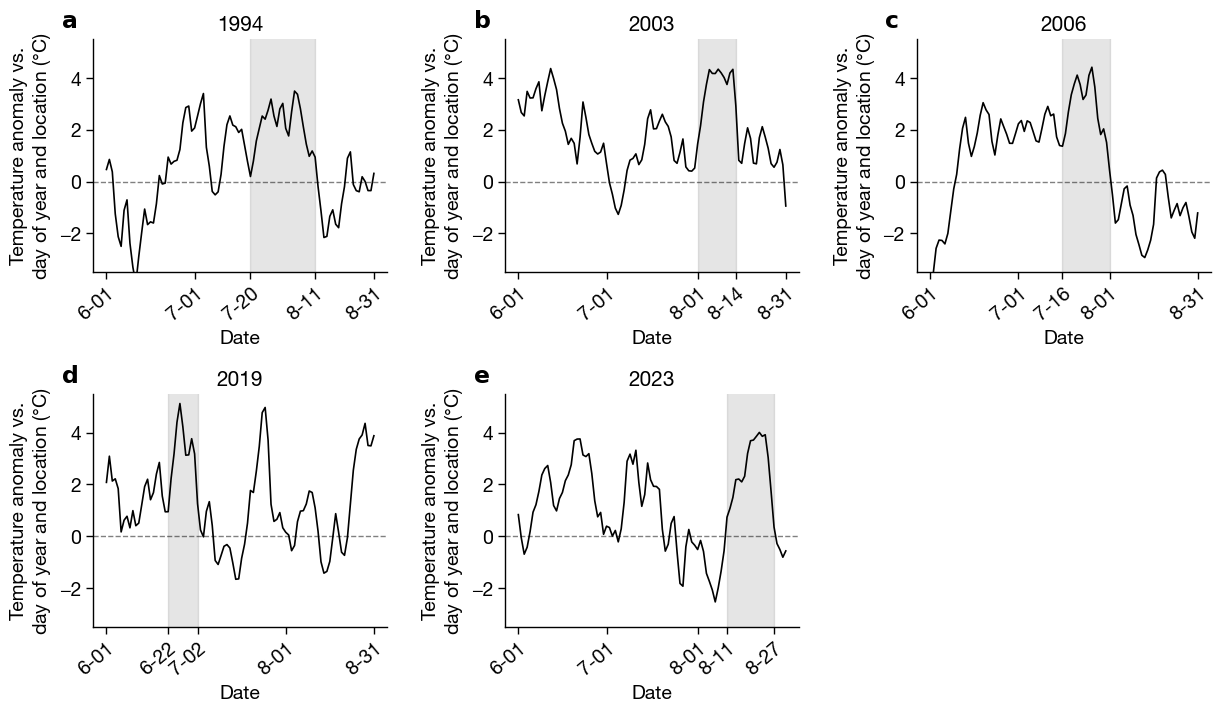

In [14]:
fig = plt.figure(figsize=(13,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

tfs = 15
lbfs = 17
lbx = -0.11
lby = 1.05

gs0 = gridspec.GridSpec(2,3)
gs0.update(left=0.09,right=0.95,top=0.95,bottom=0.11,wspace=0.4,hspace=0.52)

event_yrs = [1994,2003,2006,2019,2023]
lbs = [r"$\bf{a}$",r"$\bf{b}$",r"$\bf{c}$",r"$\bf{d}$",r"$\bf{e}$"]

for z in np.arange(0,len(event_yrs),1):
    ax = plt.subplot(gs0[z])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.axhline(y=0,color="gray",linewidth=1,linestyle="--",zorder=1)
    
    yr = event_yrs[z]
    eobs_daily_events_yr = eobs_daily_events_pop.loc[(eobs_daily_events_pop.month>=6)&(eobs_daily_events_pop.month<=8)&(eobs_daily_events_pop.year==yr),:]
    eobs_daily_events_yr1 = eobs_daily_events_yr.copy()
    eobs_mean = eobs_daily_events_yr1.dropna().groupby("time").apply(wgted_mean).reset_index() #[0] #.groupby(["time"]).mean("tm_anom").reset_index()
    tm = eobs_mean.time.values
    temp = eobs_mean[0]
    x = np.arange(1,len(eobs_mean)+1,1)
    begin = event_df.loc[event_df.event_yr==yr,"begindate"].values[0]
    end = event_df.loc[event_df.event_yr==yr,"enddate"].values[0]
    window1 = x[tm==begin][0]
    window2 = x[tm==end][0]
    
    plt.ylim([-3.5,5.5])
    #ax.fill_between([window1,window2],-5,7.5,color="black",alpha=0.1)
    plt.plot(tm,temp,color="black",linewidth=1.2,zorder=3)
    ax.fill_between([begin,end],-5,7.5,color="black",alpha=0.1,zorder=2)
    
    if yr in [1994,2003,2006]:
        x_axis = [tm[0],str(yr)+"-07-01",begin,end,tm[-1]]
    elif yr == 2019:
        x_axis = [tm[0],begin,end,"2019-08-01",tm[-1]]
    elif yr == 2023:
        x_axis = [tm[0],"2023-07-01","2023-08-01",begin,end]
        
    #x_axis = [str(z)[5:10] for z in x_axis1]
    plt.xticks(ticks=x_axis,labels=[str(x)[6:] for x in x_axis],
              rotation=40,ha="right",rotation_mode="anchor")
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=21))
            
    plt.title(str(yr),fontsize=tfs)
    plt.xlabel("Date")
    plt.ylabel("Temperature anomaly vs.\nday of year and location ($\degree$C)")
    plt.text(lbx,lby,lbs[z],fontsize=lbfs,transform=ax.transAxes)
    
plt.savefig(loc_figs+"FigX_Event_Timeseries_v2.pdf")
plt.show()

In [15]:
event_df.to_csv(loc_events+"event_definitions.csv")